<a href="https://colab.research.google.com/github/statmike/Logistic-Regression/blob/main/07_Logistic_Regression_with_BigQuery_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logistic Regression - with [BigQuery ML](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#create_model_statement)



Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import linear_model

# add bigquery
from google.cloud import bigquery

# add scikit-plot to help with assessment plots
!pip install scikit-plot
import scikitplot as skplt

# make the plots fun
plt.xkcd()

Mount Google Drive
- Only needed in the next step because I stored my BigQuery service account credentials in a Drive location.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setup path for service account credentials

In [ ]:
%env GOOGLE_APPLICATION_CREDENTIALS=/content/drive/MyDrive/Projects/statmike-project-1-cc48810e04c5.json

env: GOOGLE_APPLICATION_CREDENTIALS=/content/drive/MyDrive/Projects/statmike-project-1-cc48810e04c5.json


### BigQuery Session 
- connect
- list projects and datasets
- create dataset for this example

In [ ]:
# Construct a BigQuery client object.
client = bigquery.Client()

In [ ]:
from google.cloud.bigquery import magics
from google.oauth2 import service_account
credentials = (service_account.Credentials.from_service_account_file('/content/drive/MyDrive/Projects/statmike-project-1-cc48810e04c5.json'))
magics.context.credentials = credentials

In [ ]:
# get a list of datasets
projects = []
for item in list(client.list_projects()):
  projects.append(item.project_id)
print("projects: ",projects)
datasets = []
for item in list(client.list_datasets()):
  datasets.append(item.dataset_id)
print("datasets: ",datasets)

projects:  ['statmike-project-1']
datasets:  ['small_projects']


In [ ]:
# create dataset if missing
if 'statmike-project-1' in projects and 'small_projects' in datasets:
  print('dataset already exist')
else:
  # Construct a full Dataset object to send to the API.
  dataset = bigquery.Dataset('statmike-project-1.small_projects')
  dataset.location = "US"
  dataset = client.create_dataset(dataset)
  print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

dataset already exist


### Load Data

First load to Pandas DataFrame

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()

digits_df = pd.DataFrame(data=digits.data)
digits_df['target'] = digits.target
digits_df['target_OE'] = digits_df['target'].apply(lambda x : 'Odd' if x%2==1 else ('Even' if x%2==0 else ''))
digits_df['target_OE']

0       Even
1        Odd
2       Even
3        Odd
4       Even
        ... 
1792     Odd
1793    Even
1794    Even
1795     Odd
1796    Even
Name: target_OE, Length: 1797, dtype: object

Move data from Python (pandas dataframe) to BigQuery Table (note: it is very small)

https://cloud.google.com/bigquery/docs/samples/bigquery-load-table-dataframe

My example looks for a project named `statmike-project-1` and a dataset named `small-projects`.  If it does not find them then they are created.

In [ ]:
# rename columns with numeric names as a string of the number: 0 becomes 'p0', 1 becomes 'p1', ...
digits_df.columns = ['p'+str(i) if i <= 63 else x for i, x in enumerate(digits_df.columns,0)]

In [ ]:
# load data to digits table in BigQuery
job_config = bigquery.LoadJobConfig(schema=[],write_disposition="WRITE_TRUNCATE",)

tableid = 'statmike-project-1.small_projects.digits'
job = client.load_table_from_dataframe(digits_df, tableid, job_config=job_config)
job.result()

table = client.get_table(tableid)
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), tableid
    )
)

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery/_pandas_helpers.py:275: UserWarning: Unable to determine type of column 'target_OE'.
  warnings.warn(u"Unable to determine type of column '{}'.".format(column))


Loaded 1797 rows and 66 columns to statmike-project-1.small_projects.digits


### Query Data in BigQuery

Direct, Interactive Query

In [ ]:
# directly
query_job = client.query(
    """
    SELECT target_OE, count(*) as Count
    FROM `statmike-project-1.small_projects.digits`
    GROUP BY target_OE
    """
)

results = query_job.result()
for row in results: print(row)

Row(('Even', 891), {'target_OE': 0, 'Count': 1})
Row(('Odd', 906), {'target_OE': 0, 'Count': 1})


Query using %%bigquery magic, Interactive Query

In [ ]:
# with magic
%%bigquery
SELECT target_OE, count(*) as Count
FROM `statmike-project-1.small_projects.digits`
GROUP BY target_OE

,target_OE,Count
0,Even,891
1,Odd,906


### Use BigQuery to Create Train/Test Split
- Add a unique identifier to the rows of the table
- Create a view of the table with a test/train split variable

Add a unique identifier to the rows that can be used for repeatability in sampling for test/train splits of the data:

In [ ]:
## add a uuid to the data for evaluting the train/test split repeatably
%%bigquery
CREATE OR REPLACE TABLE `statmike-project-1.small_projects.digits` AS
SELECT *, GENERATE_UUID() as uuid
FROM `statmike-project-1.small_projects.digits`

""


Create a view of the table that contains the test/train split column (splits)

In [ ]:
# a view with the splits column
%%bigquery
CREATE OR REPLACE VIEW
  `statmike-project-1.small_projects.digits_view` AS
SELECT
  * EXCEPT(UUID),
  CASE
    WHEN MOD(ABS(FARM_FINGERPRINT(UUID)),10) < 8 THEN 'train'
    ELSE 'test'
  END AS splits
FROM
  `statmike-project-1.small_projects.digits`

""


Review the split of test and train data - using a group by query

In [ ]:
%%bigquery
SELECT splits, count(*) as Count
FROM `statmike-project-1.small_projects.digits_view`
GROUP BY splits

,splits,Count
0,test,377
1,train,1420


### Logistic Regression in BigQuery

#### Simple, Binary Response
- multivariate (more than one factor, x)
- no missing data
- no variable selection (estimate a parameter for each factor, x)
- no higher order terms (no cross features, interactions, polynomial terms)

Use `CREATE MODEL` to do logistic regression in BigQuery

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-project-1.small_projects.lr_digits`
OPTIONS
  ( model_type='LOGISTIC_REG',
    auto_class_weights=TRUE,
    input_label_cols=['target_OE']
  ) AS
SELECT * EXCEPT(splits,target)
FROM `statmike-project-1.small_projects.digits_view`
WHERE splits = 'train'

""


Review the training info, like loss, over the iterations:

In [ ]:
%%bigquery
SELECT *
FROM ML.TRAINING_INFO(MODEL `statmike-project-1.small_projects.lr_digits`)
ORDER BY iteration 

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.578033,0.579845,0.2,4707
1,0,1,0.461906,0.463664,0.4,4763
2,0,2,0.374835,0.377651,0.8,4740
3,0,3,0.309977,0.320367,1.6,4971
4,0,4,0.260008,0.282568,3.2,4877
5,0,5,0.225909,0.254089,6.4,5346


##### Evaluate Model on Training Data

In [ ]:
%%bigquery
SELECT *
FROM ML.EVALUATE (MODEL `statmike-project-1.small_projects.lr_digits`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`
    WHERE splits = 'train')
  );

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.906877,0.899148,0.904225,0.902996,0.231644,0.971462


In [ ]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `statmike-project-1.small_projects.lr_digits`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`
    WHERE splits = 'train')
  )

,expected_label,Even,Odd
0,Even,651,65
1,Odd,71,633


In [ ]:
%%bigquery roc
SELECT *
FROM ML.ROC_CURVE(MODEL `statmike-project-1.small_projects.lr_digits`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`
    WHERE splits = 'train')
  )

Text(0.5, 1.0, 'ROC Curve for')

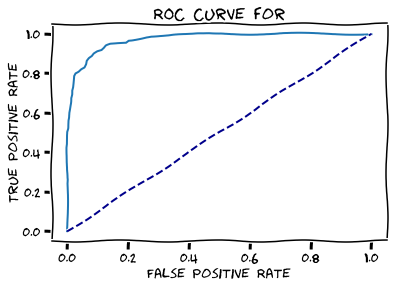

In [ ]:
plt.plot(roc.false_positive_rate, roc.recall)
plt.plot([0,1],[0,1],color='darkblue',linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for')

In [ ]:
%%bigquery pr
SELECT recall, true_positives / (true_positives + false_positives) AS precision
FROM ML.ROC_CURVE(MODEL `statmike-project-1.small_projects.lr_digits`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`
    WHERE splits = 'train')
  )

Text(0.5, 1.0, 'Precision-Recall Curve')

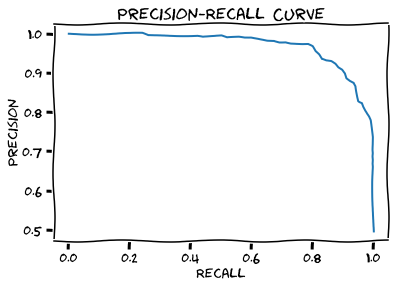

In [ ]:
plt.plot(pr.recall, pr.precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

##### Evaluate Model on Test Data

In [ ]:
params = {'split' : 'test'}

In [ ]:
%%bigquery --params $params
SELECT *
FROM ML.EVALUATE (MODEL `statmike-project-1.small_projects.lr_digits`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`
    WHERE splits = @split)
  )

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.932367,0.955446,0.938992,0.943765,0.184384,0.984851


In [ ]:
%%bigquery --params $params
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `statmike-project-1.small_projects.lr_digits`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`
    WHERE splits = @split)
  )

,expected_label,Even,Odd
0,Even,161,14
1,Odd,9,193


In [ ]:
%%bigquery roc --params $params
SELECT *
FROM ML.ROC_CURVE(MODEL `statmike-project-1.small_projects.lr_digits`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`
    WHERE splits = @split)
  )

Text(0.5, 1.0, 'ROC Curve for')

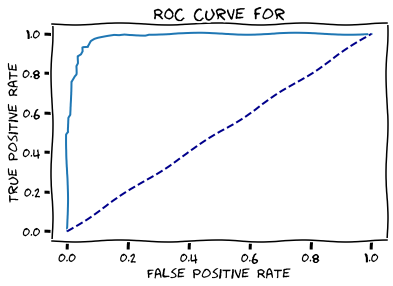

In [ ]:
plt.plot(roc.false_positive_rate, roc.recall)
plt.plot([0,1],[0,1],color='darkblue',linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for')

In [ ]:
%%bigquery pr --params $params
SELECT recall, true_positives / (true_positives + false_positives) AS precision
FROM ML.ROC_CURVE(MODEL `statmike-project-1.small_projects.lr_digits`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`
    WHERE splits = @split)
  )

Text(0.5, 1.0, 'Precision-Recall Curve')

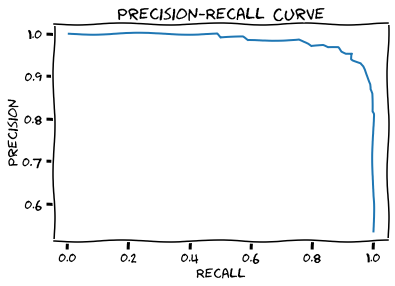

In [ ]:
plt.plot(pr.recall, pr.precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

#### Simple, Multiclass (3 or more responses)
- multivariate
- no missing data
- no variable selection
- no higher order terms


Use `CREATE MODEL` to do logistic regression in BigQuery

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-project-1.small_projects.lr_digits_mc`
OPTIONS
  ( model_type='LOGISTIC_REG',
    auto_class_weights=TRUE,
    input_label_cols=['target']
  ) AS
SELECT * EXCEPT(splits,target_OE)
FROM `statmike-project-1.small_projects.digits_view`
WHERE splits = 'train'

""


Review the training info, like loss, over the iterations:

In [ ]:
%%bigquery
SELECT *
FROM ML.TRAINING_INFO(MODEL `statmike-project-1.small_projects.lr_digits_mc`)
ORDER BY iteration 

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.195190,0.194541,0.2,4448
1,0,1,0.142616,0.141514,0.4,6045
2,0,2,0.088346,0.088100,0.8,5805
3,0,3,0.053008,0.054466,1.6,5459
4,0,4,0.033427,0.036021,3.2,9192
5,0,5,0.022271,0.024886,6.4,5963
6,0,6,0.016456,0.020917,12.8,112929
7,0,7,0.014432,0.018243,3.2,6220
8,0,8,0.013123,0.017548,6.4,7026
9,0,9,0.011231,0.016078,12.8,6485


Evaluate Model on Training Data

In [ ]:
%%bigquery
SELECT *
FROM ML.EVALUATE (MODEL `statmike-project-1.small_projects.lr_digits_mc`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`
    WHERE splits = 'train')
  );

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.97977,0.979586,0.979577,0.97961,0.121472,0.999699


In [ ]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `statmike-project-1.small_projects.lr_digits_mc`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`
    WHERE splits = 'train')
  )

,expected_label,_0,_1,_2,_3,_4,_5,_6,_7,_8,_9
0,0,147,0,0,0,0,0,0,0,0,0
1,1,0,143,0,0,0,0,1,0,1,2
2,2,0,0,141,0,0,0,0,0,0,0
3,3,0,0,1,136,0,1,0,1,2,0
4,4,0,0,0,0,142,0,0,0,1,1
5,5,0,1,0,0,0,137,1,0,0,2
6,6,0,1,0,0,0,1,136,0,0,0
7,7,0,0,0,0,0,0,0,139,0,1
8,8,0,4,1,0,0,1,1,0,139,0
9,9,0,2,0,0,0,0,0,0,2,131


##### Use ML.PREDICT results for evaluting the model

In [ ]:
%%bigquery pred
SELECT target, predicted_target, predicted_target_probs, splits
FROM ML.PREDICT(MODEL `statmike-project-1.small_projects.lr_digits_mc`,(
    SELECT *
    FROM `statmike-project-1.small_projects.digits_view`)
  )



---
>**Side Note - the BigQuery STRUCT data type:**
>
>When using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict#mlpredict_function) for a classification model, the column `predicted_<target>_probs` is of type [STRUCT](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types#struct_type).  This is considered a [nested/repeated columns](https://cloud.google.com/bigquery/docs/nested-repeated).  
>
>> Another nested/repeated column type is [ARRAY](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types#array_type). This differs from the STRUCT type as it is an ordered list.  It is also possible to [nest](https://cloud.google.com/bigquery/docs/nested-repeated#limitations) STRUCT and ARRAY types.
>
>In this case, each class label and corresponding probability are stored in the nested columns within the struct (`label`, `prob`). 
>
>Retrieving this information requires consideration at either the query level or the pandas dataframe level of the response.  
>
>Helpful Information on this topic:
- [Working with arrays](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays)
  - Nesting:
    - [STRUCT within a ARRAY](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#query_structs_in_an_array)
    - [ARRAY within a STRUCT](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#querying_array-type_fields_in_a_struct)
    - [ARRAY of ARRAYs (using a STRUCT)](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#building_arrays_of_arrays)
  - [Array functions](https://cloud.google.com/bigquery/docs/reference/standard-sql/array_functions)
  - [UNNEST operator](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#unnest)

---



Given the note above, we did not adjust the query to consider the `STRUCT` type of `predicted_target_probs` and it was returned to the dataframe as a list of dictionaries.  This will be unpacked with a Python function a bit later.

In [ ]:
pred.head()

,target,predicted_target,predicted_target_probs,splits
0,0,0,"[{'label': 0, 'prob': 0.9970980661573137}, {'l...",test
1,0,0,"[{'label': 0, 'prob': 0.8072516183273899}, {'l...",train
2,0,0,"[{'label': 0, 'prob': 0.9988699483562941}, {'l...",train
3,0,0,"[{'label': 0, 'prob': 0.9322147180078105}, {'l...",train
4,0,0,"[{'label': 0, 'prob': 0.9927123623860777}, {'l...",test


In [ ]:
print("Training Data Classification Report")
print(sk.metrics.classification_report(pred.target[pred.splits=='train'], pred.predicted_target[pred.splits=='train']))
print("Test Data Classification Report")
print(sk.metrics.classification_report(pred.target[pred.splits=='test'], pred.predicted_target[pred.splits=='test']))

Training Data Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       0.95      0.97      0.96       147
           2       0.99      1.00      0.99       141
           3       1.00      0.96      0.98       141
           4       1.00      0.99      0.99       144
           5       0.98      0.97      0.98       141
           6       0.98      0.99      0.98       138
           7       0.99      0.99      0.99       140
           8       0.96      0.95      0.96       146
           9       0.96      0.97      0.96       135

    accuracy                           0.98      1420
   macro avg       0.98      0.98      0.98      1420
weighted avg       0.98      0.98      0.98      1420

Test Data Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       0.94      0.94      0.94        35
          

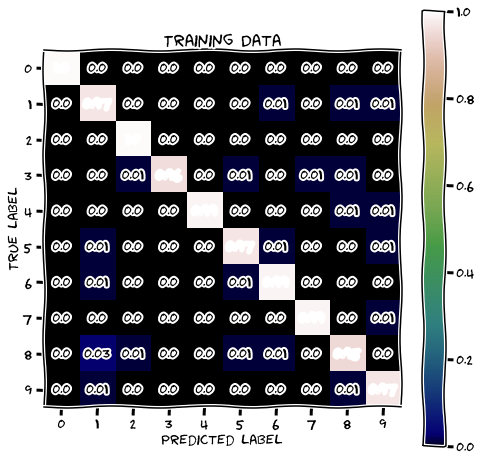

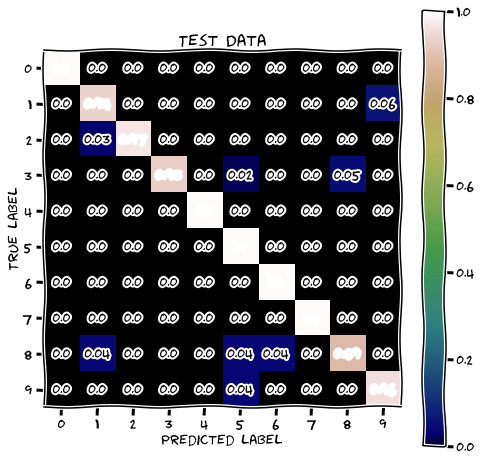

In [ ]:
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,8))
skplt.metrics.plot_confusion_matrix(pred.target[pred.splits=='train'], pred.predicted_target[pred.splits=='train'], normalize=True, title='Training Data', figsize=(8,8), cmap='gist_earth')
skplt.metrics.plot_confusion_matrix(pred.target[pred.splits=='test'], pred.predicted_target[pred.splits=='test'], normalize=True, title='Test Data', figsize=(8,8), cmap='gist_earth')

Remember the list of dictionaires we mentioned above?  Those list hold the probabilities for each class level for each row of the predictions.  Now we want to unpack those to use with plotting ROC and PR curves for each class level. The following python function achieves this - check out the comments embedded within:

In [ ]:
def probs(df,split):
  # convert to predicted_target_probs to a list of list of dictionaires (label, prob)
  a = df[df.splits==split].predicted_target_probs.to_list()
  # sort the sublist of dictionaries by element label: 0, 1, 2, ... 9
  b = [sorted(x, key = lambda x: x['label']) for x in a]
  # create a list of list of ordered prob values
  c = [[d['prob'] for d in x] for x in b]
  return c

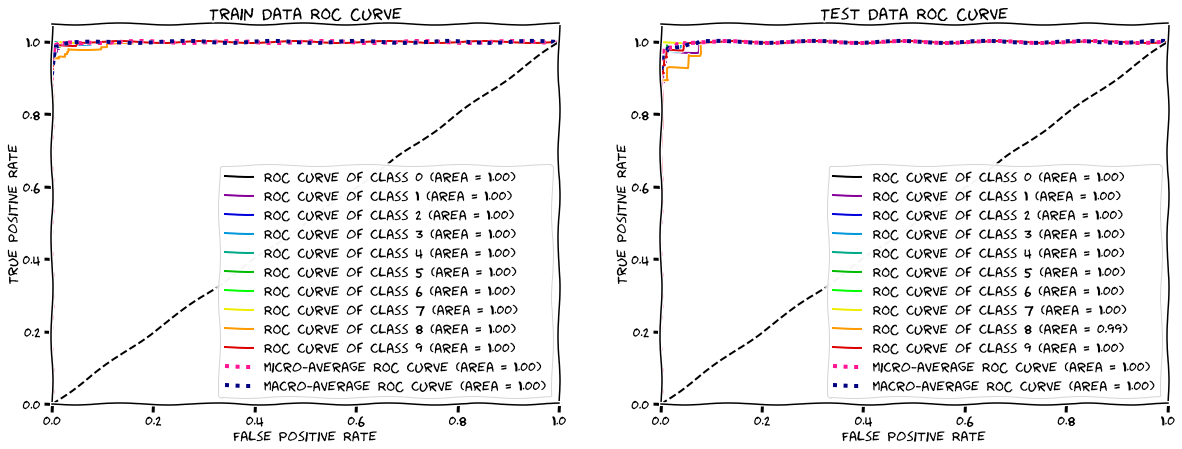

In [ ]:
# roc
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
skplt.metrics.plot_roc(pred.target[pred.splits=='train'], probs(pred,'train'),figsize=(10,7),ax=ax1, title='Train Data ROC Curve')
skplt.metrics.plot_roc(pred.target[pred.splits=='test'], probs(pred,'test'),figsize=(10,7),ax=ax2, title='Test Data ROC Curve')

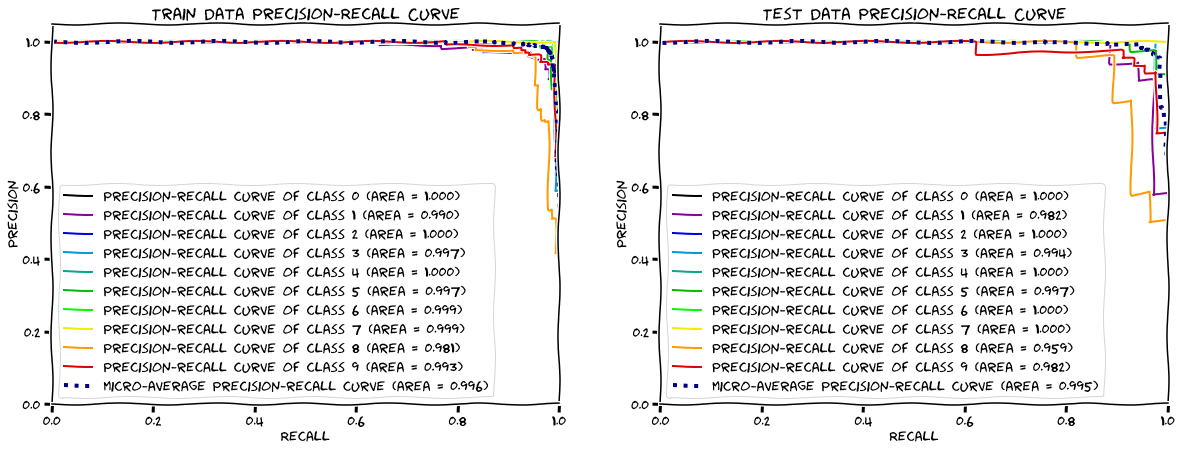

In [ ]:
# pr here
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
skplt.metrics.plot_precision_recall(pred.target[pred.splits=='train'], probs(pred,'train'),figsize=(10,7),ax=ax1, title='Train Data Precision-Recall Curve')
skplt.metrics.plot_precision_recall(pred.target[pred.splits=='test'], probs(pred,'test'),figsize=(10,7),ax=ax2, title='Test Data Precision-Recall Curve')